In [1]:
# Import findspark
import findspark
findspark.init()

# Import pyspark
from pyspark import SparkFiles

# Import pyspark sql functions
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when
from pyspark.sql.functions import when, col
from pyspark.sql.functions import when
from pyspark.sql.functions import mean
from pyspark.sql.functions import concat, lit
from pyspark.sql.functions import avg, col

# Import Pandas and Numpy
import pandas as pd
import numpy as np

# Import Sklearn for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Import StandardScaler for scaling numeric features
from sklearn.preprocessing import StandardScaler

# Import Matplot and seaborn for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Import plotly us and mplcursors
import plotly.graph_objects as go
import us
import plotly.express as px
import mplcursors
import matplotlib as mpl

# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparkFunctions").getOrCreate()

24/10/10 13:25:08 WARN Utils: Your hostname, Jons-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.154 instead (on interface en0)
24/10/10 13:25:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/10 13:25:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark import SparkFiles
csv_file_paths = [
    "Resources/CurrentPopulationSurvey_1981.csv",
    "Resources/CurrentPopulationSurvey_1990.csv",
    "Resources/CurrentPopulationSurvey_1999.csv",
    "Resources/CurrentPopulationSurvey_2007.csv",
    "Resources/CurrentPopulationSurvey_2009.csv",
    "Resources/CurrentPopulationSurvey_2011.csv",
    "Resources/CurrentPopulationSurvey_2013.csv"
]

dfs = [spark.read.csv(path, sep=",", header=True, ignoreLeadingWhiteSpace=True) for path in csv_file_paths]

combined_df = dfs[0]
for df in dfs [1:]:
    combined_df = combined_df.union(df)

# Show DataFrame
combined_df.show(5)

+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+
|year|          state name| region_1|age|sex_1|       race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|
+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+
|1981|            Virginia|    South| 38| male|Other nonhisp|Married, spouse p...|      NULL|  NULL|245|798|      52|      40|17000.0|
|1981|             Vermont|Northeast| 58| male|White nonhisp|Married, spouse p...|      NULL|  NULL|470|339|      52|      48|19000.0|
|1981|                Utah|     West| 35| male|White nonhisp|Married, spouse p...|      NULL|  NULL|715|417|      52|      43|21000.0|
|1981|            Illinois|  Midwest| 33| male|White nonhisp|            Divorced|      NULL|  NULL|485|857|      52|      60|19740.0|
|1981|District of Columbia|    South| 45| male|Black no

In [3]:
#Create a Python dictionary to store CPI values for each year
cpi_dict = {
    1981: 87.00,
    1990: 127.40,
    1999: 164.30,
    2007: 202.416,
    2009: 211.143,
    2011: 220.223,
    2013: 230.280
}

# base year for inflation adjustment 
base_year_cpi = cpi_dict[2013]

# Adjust 'incwage' for inflation based on the CPI values
real_wage_data = combined_df.withColumn(
    'real_wage', 
    when(col('year') == 1981, (col('incwage') / cpi_dict[1981]) * base_year_cpi)
    .when(col('year') == 1990, (col('incwage') / cpi_dict[1990]) * base_year_cpi)
    .when(col('year') == 1999, (col('incwage') / cpi_dict[1999]) * base_year_cpi)
    .when(col('year') == 2007, (col('incwage') / cpi_dict[2007]) * base_year_cpi)
    .when(col('year') == 2009, (col('incwage') / cpi_dict[2009]) * base_year_cpi)
    .when(col('year') == 2011, (col('incwage') / cpi_dict[2011]) * base_year_cpi)
    .when(col('year') == 2013, (col('incwage') / cpi_dict[2013]) * base_year_cpi)
    .otherwise(col('incwage'))  # In case any year falls outside the defined years
)

# Show the updated rows with the real wages
real_wage_data.show(5)

+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+------------------+
|year|          state name| region_1|age|sex_1|       race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|         real_wage|
+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+------------------+
|1981|            Virginia|    South| 38| male|Other nonhisp|Married, spouse p...|      NULL|  NULL|245|798|      52|      40|17000.0| 44997.24137931035|
|1981|             Vermont|Northeast| 58| male|White nonhisp|Married, spouse p...|      NULL|  NULL|470|339|      52|      48|19000.0| 50291.03448275862|
|1981|                Utah|     West| 35| male|White nonhisp|Married, spouse p...|      NULL|  NULL|715|417|      52|      43|21000.0|  55584.8275862069|
|1981|            Illinois|  Midwest| 33| male|White nonhisp|            Div

In [4]:
# Calculate average wages by gender and year
avg_wage_by_gender_year = real_wage_data.groupBy('year', 'sex_1').agg({'real_wage': 'mean'})

# Pivot the table to get separate columns for male and female wages
pay_gap = avg_wage_by_gender_year.groupBy('year').pivot('sex_1').agg({'avg(real_wage)': 'mean'})

# Calculate pay gap: Difference between male and female average wages
pay_gap = pay_gap.withColumn('PayGap', pay_gap['male'] - pay_gap['female'])

# Order by 'year' after calculating the pay gap
pay_gap = pay_gap.orderBy('year')

# Show the results
pay_gap.show(5)

+----+------------------+------------------+------------------+
|year|            female|              male|            PayGap|
+----+------------------+------------------+------------------+
|1981|26200.225486950847| 51526.80137115999|25326.575884209145|
|1990|32133.479079493907| 53983.27308826582|21849.794008771914|
|1999| 36667.03188183436|58973.274545825734|22306.242663991376|
|2007|40871.004826902616|63641.132025883824| 22770.12719898121|
|2009| 41611.57857214943|64542.330664655194| 22930.75209250576|
+----+------------------+------------------+------------------+
only showing top 5 rows



In [5]:
# Analyzing pay gap by age group

# Create age brackets
real_wage_data = real_wage_data.withColumn(
    'AgeBracket',
    when((real_wage_data['age'] >= 20) & (real_wage_data['age'] < 30), '20-30')
    .when((real_wage_data['age'] >= 30) & (real_wage_data['age'] < 40), '30-40')
    .when((real_wage_data['age'] >= 40) & (real_wage_data['age'] < 50), '40-50')
    .otherwise('50+')
)

# Calculate average wages by gender and age bracket
pay_gap_by_age = real_wage_data.groupBy('AgeBracket', 'sex_1').agg({'real_wage': 'mean'}).orderBy('AgeBracket')
pay_gap_by_age.show()

+----------+------+------------------+
|AgeBracket| sex_1|    avg(real_wage)|
+----------+------+------------------+
|     20-30|female| 30318.15163110477|
|     20-30|  male|39342.613101695664|
|     30-40|female| 36953.09538304095|
|     30-40|  male| 56204.86917530093|
|     40-50|  male| 67553.34472535251|
|     40-50|female| 40541.53404475129|
|       50+|female| 40293.01140186898|
|       50+|  male| 66209.95275574058|
+----------+------+------------------+



Text(0, 0.5, 'Pay Gap (Male - Female Average Salary)')

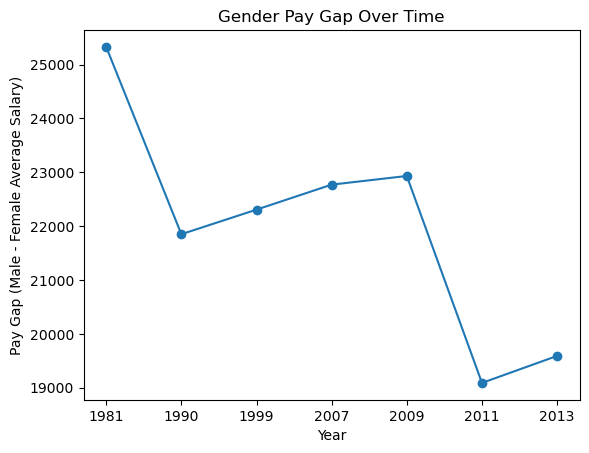

In [6]:
# Convert Spark DataFrame to Pandas for visualization
pay_gap_pandas = pay_gap.toPandas()

# Plot the gender pay gap over time
plt.plot(pay_gap_pandas['year'], pay_gap_pandas['PayGap'], marker='o')
plt.title('Gender Pay Gap Over Time')
plt.xlabel('Year')
plt.ylabel('Pay Gap (Male - Female Average Salary)')

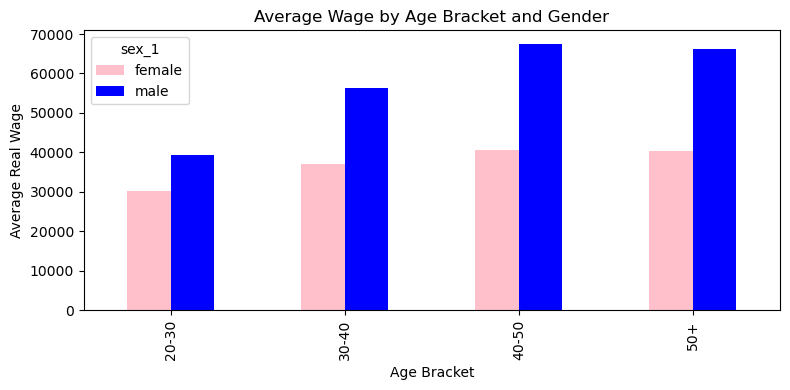

In [7]:
# Convert Spark DataFrame to Pandas
pay_gap_by_age_pd = pay_gap_by_age.toPandas()

# Pivot the DataFrame to have separate columns for male and female real wages
pay_gap_by_age_pivot = pay_gap_by_age_pd.pivot(index='AgeBracket', columns='sex_1', values='avg(real_wage)').fillna(0)

# Set up the plot with the new pivoted DataFrame
ax = pay_gap_by_age_pivot.plot(kind='bar', stacked=False, figsize=(8, 4), color=['pink', 'blue'])

# Set plot labels and title
plt.title('Average Wage by Age Bracket and Gender')
plt.xlabel('Age Bracket')
plt.ylabel('Average Real Wage')

# Display the plot
plt.tight_layout()
plt.show()

In [8]:

# Step 1: Group by occupation and gender, and calculate the average salary
occupations = real_wage_data.groupBy(['occ', 'sex_1']).agg(F.mean('real_wage').alias('avg_salary'))

# Step 2: Pivot the DataFrame to get male and female salaries in separate columns
occupations_pivoted = occupations.groupBy('occ').pivot('sex_1').agg(F.first('avg_salary')).na.fill(0)

# Step 3: Calculate total salary (sum of male and female average salaries) and get top 10 occupations
occupations_pivoted = occupations_pivoted.withColumn('total_salary', occupations_pivoted['male'] + occupations_pivoted['female'])
top_occupations = occupations_pivoted.orderBy('total_salary', ascending=False).limit(10)

# Drop rows where 'occ' is 66, 1520 or 84 (difficulty finding occ codes)
top_occupations = top_occupations[~top_occupations['occ'].isin([66, 84, 1520])]

# Verify that the rows were dropped
top_occupations.head(8)


[Row(occ='3060', female=143920.7629554128, male=226480.12369363668, total_salary=370400.88664904947),
 Row(occ='10', female=127482.20915185273, male=184096.63110707406, total_salary=311578.8402589268),
 Row(occ='2100', female=125707.48322237715, male=181693.26327849666, total_salary=307400.7465008738),
 Row(occ='1800', female=135396.45647439995, male=153717.15237753253, total_salary=289113.60885193245),
 Row(occ='3010', female=111030.20629405118, male=175785.67576427708, total_salary=286815.88205832825),
 Row(occ='3256', female=136872.0099008732, male=141467.89081975998, total_salary=278339.9007206332),
 Row(occ='1200', female=123046.55075368396, male=153825.3699617469, total_salary=276871.92071543087)]

In [9]:
# Step 4: Convert to Pandas DataFrame for plotting
top_occupations_pd = top_occupations.toPandas()

# Step 5: Replace 'occ' numeric values with descriptive labels
occupation_mapping = {
    3060: 'Physician',
    10: 'CEO',
    2100: 'Lawyer',
    1800: 'Economist',
    3010: 'Dentist',
    3256: 'Nurse Anesthetists',
    1200: 'Actuary',
    1520: 'Petroleum Engineer'
}
# Ensure the 'occ' column is cast to integer before replacing
top_occupations_pd['occ'] = top_occupations_pd['occ'].astype(int)

# Replace all 'occ' values with descriptive names from the mapping dictionary
top_occupations_pd['occ'] = top_occupations_pd['occ'].replace(occupation_mapping)
top_occupations_pd.head(10)

,occ,female,male,total_salary
0,Physician,143920.762955,226480.123694,370400.886649
1,CEO,127482.209152,184096.631107,311578.840259
2,Lawyer,125707.483222,181693.263278,307400.746501
3,Economist,135396.456474,153717.152378,289113.608852
4,Dentist,111030.206294,175785.675764,286815.882058
5,Nurse Anesthetists,136872.009901,141467.890820,278339.900721
6,Actuary,123046.550754,153825.369962,276871.920715


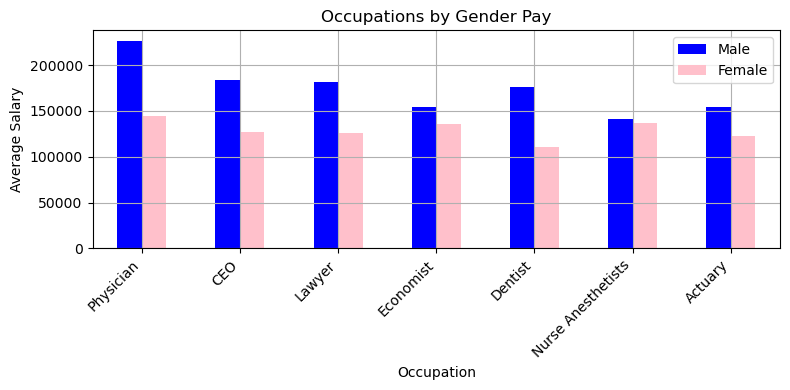

In [10]:
# Step 6: Plot the top 10 occupations with a bar chart using descriptive labels
top_occupations_pd.set_index('occ')[['male', 'female']].plot(kind='bar', stacked=False, figsize=(8, 4), color=['blue', 'pink'])

# Tilt the x-axis labels
plt.xticks(rotation=45, ha='right')

# Step 7: Add labels and title
plt.title('Occupations by Gender Pay')
plt.xlabel('Occupation')
plt.ylabel('Average Salary')
plt.legend(['Male', 'Female'], loc='upper right')
plt.grid(True)

# Step 8: Show the plot
plt.tight_layout()
plt.show()

In [11]:

# Step 1: Filter for women (assuming 'sex_1' = 'female' represents women)
women_occupations = real_wage_data.filter(real_wage_data['sex_1'] == 'female')

# Step 2: Group by occupation code and calculate the count of women and average real wage
women_occupation_stats = women_occupations.groupBy('occ').agg(
    F.count('*').alias('count'),
    F.mean('real_wage').alias('avg_real_wage')
)

# Step 3: Order by the number of women in each occupation (descending) and get the top 10
top_women_occupations = women_occupation_stats.orderBy('count', ascending=False).limit(10)

# Step 4: Drop rows where 'occ' is 313, 3130, 4700(for filtering out specific occupations)
top_women_occupations = top_women_occupations.filter(~top_women_occupations['occ'].isin([313, 3130, 4700]))

# Step 5: Convert to Pandas for verification or further analysis
top_women_occupations = top_women_occupations.toPandas()

# Step 6: Show the top 8 rows
print(top_women_occupations.head(8))



    occ  count  avg_real_wage
0  5700   5414   35357.415812
1  2310   4883   45317.675830
2  3600   2919   23695.796025
3  3255   2515   59538.986258
4  4720   2368   17987.138296
5  5240   2152   34135.185578
6  4230   2108   17921.682387


In [12]:
# Step 5: Replace 'occ' numeric values with descriptive labels
occ_women_mapping = {
    5700: 'Secretary',
    2310: 'Teacher',
    3600: 'Nurses Aide',
    3255: 'Registered Nurse',
    4720: 'Cashier',
    5240: 'Customer Service Representative',
    4230: 'Maid'
}
# Ensure the 'occ' column is cast to integer before replacing
top_women_occupations['occ'] = top_women_occupations['occ'].astype(int)

# Replace all 'occ' values with descriptive names from the mapping dictionary
top_women_occupations['occ'] = top_women_occupations['occ'].replace(occ_women_mapping)
top_women_occupations.head()

,occ,count,avg_real_wage
0,Secretary,5414,35357.415812
1,Teacher,4883,45317.675830
2,Nurses Aide,2919,23695.796025
3,Registered Nurse,2515,59538.986258
4,Cashier,2368,17987.138296


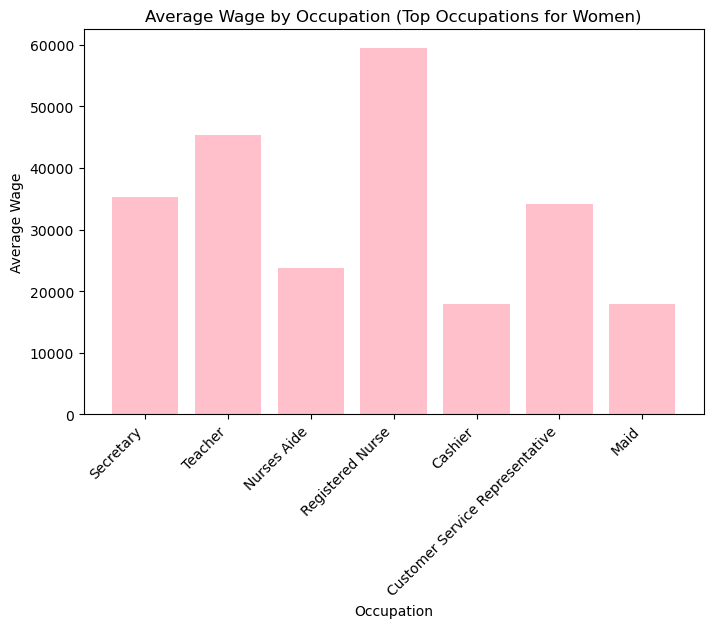

In [13]:
# Step 7: Plot the graph
plt.figure(figsize=(8, 5))
plt.bar(top_women_occupations['occ'], top_women_occupations['avg_real_wage'], color='pink')
plt.xlabel('Occupation')
plt.ylabel('Average Wage')
plt.title('Average Wage by Occupation (Top Occupations for Women)')
plt.xticks(rotation=45, ha='right')  # Tilt the x-axis labels for readability

# Show the plot
plt.show()

In [14]:
# Step 1: Filter for women (assuming 'sex_1' = 'female' represents women)
men_occupations = real_wage_data.filter(real_wage_data['sex_1'] == 'male')

# Step 2: Group by occupation code and calculate the count of women and average real wage
men_occupation_stats = men_occupations.groupBy('occ').agg(
    F.count('*').alias('count'),
    F.mean('real_wage').alias('avg_real_wage')
)

# Step 3: Order by the number of women in each occupation (descending) and get the top 10
top_men_occupations = men_occupation_stats.orderBy('count', ascending=False).limit(10)

# Step 4: Drop rows where 'occ' is 245, 19, 4700(for filtering out specific occupations)
top_men_occupations = top_men_occupations.filter(~top_men_occupations['occ'].isin([245, 19, 4700]))

# Step 5: Convert to Pandas for verification or further analysis
top_men_occupations = top_men_occupations.toPandas()

# Step 6: Show the top 8 rows
print(top_men_occupations.head(8))

    occ  count  avg_real_wage
0  9130   4918   44751.837132
1   430   3143   89548.016678
2  4220   2286   28793.194728
3  9620   1964   31899.031291
4  4760   1723   50595.392361
5  6260   1675   33138.059027
6   804   1628   44130.121854


In [15]:
# Step 5: Replace 'occ' numeric values with descriptive labels
occ_men_mapping = {
    9130: 'Truck Driver',
    430: 'Manager',
    4220: 'Janitor',
    9620: 'Laborer',
    4760: 'Sales',
    6260: 'Construction',
    804: 'Accountant',
}
# Ensure the 'occ' column is cast to integer before replacing
top_men_occupations['occ'] = top_men_occupations['occ'].astype(int)

# Replace all 'occ' values with descriptive names from the mapping dictionary
top_men_occupations['occ'] = top_men_occupations['occ'].replace(occ_men_mapping)
top_men_occupations.head()

,occ,count,avg_real_wage
0,Truck Driver,4918,44751.837132
1,Manager,3143,89548.016678
2,Janitor,2286,28793.194728
3,Laborer,1964,31899.031291
4,Sales,1723,50595.392361


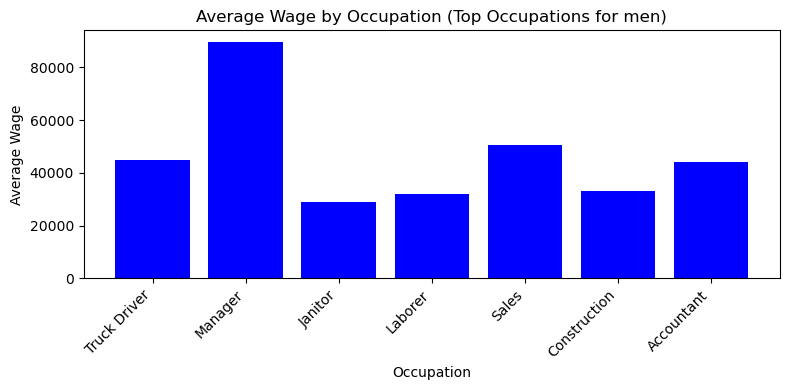

In [16]:
# Step 7: Plot the graph
plt.figure(figsize=(8, 4))
plt.bar(top_men_occupations['occ'], top_men_occupations['avg_real_wage'], color='blue')
plt.xlabel('Occupation')
plt.ylabel('Average Wage')
plt.title('Average Wage by Occupation (Top Occupations for men)')
plt.xticks(rotation=45, ha='right')  # Tilt the x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# Group by 'industry' and 'sex_1', then calculate the mean income
grouped_data = combined_df.groupBy(['ind', 'sex_1']).agg(F.mean('incwage').alias('average_income'))

# Pivot to create a wide-format DataFrame
industries = grouped_data.groupBy('ind').pivot('sex_1').agg(F.first('average_income'))

# Show the final output
industries.show(5)

+----+------------------+------------------+
| ind|            female|              male|
+----+------------------+------------------+
| 467|          12962.54|23124.873646209388|
| 829|           8890.48|         38091.875|
| 691|          20293.75|35968.230769230766|
|1090|35828.368055555555| 47134.19626168224|
| 800|24745.752808988764| 42802.96923076923|
+----+------------------+------------------+
only showing top 5 rows



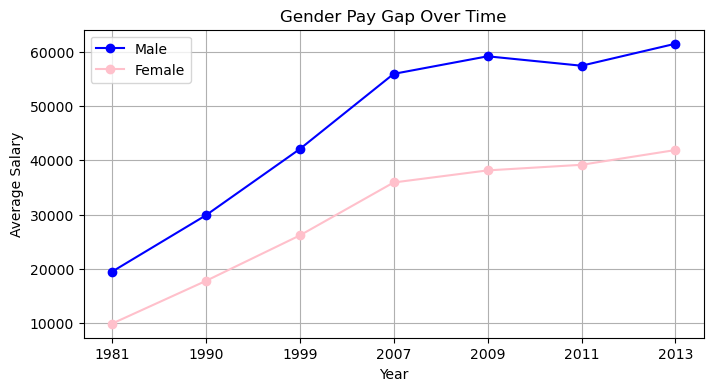

In [18]:
male_data = combined_df[combined_df['sex_1'] == 'male']
female_data = combined_df[combined_df['sex_1'] == 'female']

# First, calculate average salary for males and females grouped by year
avg_salary_male_year = male_data.groupBy('year').agg({'incwage': 'mean'}).withColumnRenamed('avg(incwage)', 'avg_salary')
avg_salary_female_year = female_data.groupBy('year').agg({'incwage': 'mean'}).withColumnRenamed('avg(incwage)', 'avg_salary')

# Convert the results to Pandas DataFrames for plotting
avg_salary_male_year_pd = avg_salary_male_year.toPandas()
avg_salary_female_year_pd = avg_salary_female_year.toPandas()

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(avg_salary_male_year_pd['year'], avg_salary_male_year_pd['avg_salary'], label='Male', color='blue', marker='o')
plt.plot(avg_salary_female_year_pd['year'], avg_salary_female_year_pd['avg_salary'], label='Female', color='pink', marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('Gender Pay Gap Over Time')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


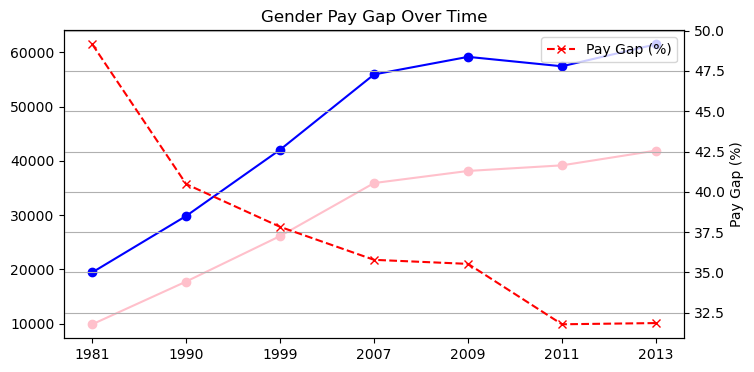

In [19]:
# Merge the male and female salary dataframes on the 'year' column
merged_df = avg_salary_male_year_pd.merge(avg_salary_female_year_pd, on='year', suffixes=('_male', '_female'))

# Calculate the percentage pay gap
merged_df['pay_gap_percentage'] = ((merged_df['avg_salary_male'] - merged_df['avg_salary_female']) / merged_df['avg_salary_male']) * 100

# Plotting
plt.figure(figsize=(8, 4))

# Plot the average salary for males and females
plt.plot(merged_df['year'], merged_df['avg_salary_male'], label='Male Avg Salary', color='blue', marker='o')
plt.plot(merged_df['year'], merged_df['avg_salary_female'], label='Female Avg Salary', color='pink', marker='o')

# Add secondary y-axis for the pay gap percentage
ax2 = plt.gca().twinx()  # Create a secondary axis
ax2.plot(merged_df['year'], merged_df['pay_gap_percentage'], label='Pay Gap (%)', color='red', marker='x', linestyle='--')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Salary')
ax2.set_ylabel('Pay Gap (%)')
plt.title('Gender Pay Gap Over Time')

# Add legends for both plots
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot with grid
plt.grid(True)
plt.show()


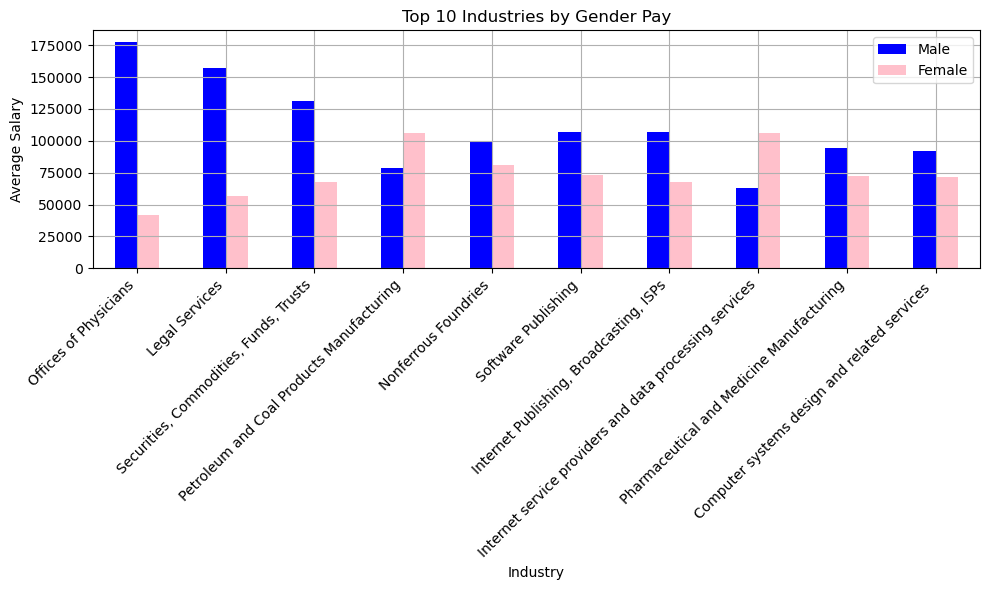

In [20]:
# Define the mapping of industry codes to descriptive names
industry_mapping = {
    '7970': 'Offices of Physicians',
    '7270': 'Legal Services',
    '6970': 'Securities, Commodities, Funds, Trusts',
    '6870': 'Banking and Related Activities',
    '3360': 'Nonferrous Foundries',
    '6490': 'Software Publishing',
    '6672': 'Internet Publishing, Broadcasting, ISPs',
    '2190': 'Pharmaceutical and Medicine Manufacturing',
    '480': 'Petroleum and Coal Products Manufacturing'
}

# Create a new column with descriptive names using `F.when()` to map the codes
combined_df = combined_df.withColumn('ind_name', 
    F.when(F.col('ind') == '7970', 'Offices of Physicians')
    .when(F.col('ind') == '7270', 'Legal Services')
    .when(F.col('ind') == '6970', 'Securities, Commodities, Funds, Trusts')
    .when(F.col('ind') == '6870', 'Banking and Related Activities')
    .when(F.col('ind') == '3360', 'Nonferrous Foundries')
    .when(F.col('ind') == '6490', 'Software Publishing')
    .when(F.col('ind') == '6672', 'Internet Publishing, Broadcasting, ISPs')
    .when(F.col('ind') == '2190', 'Pharmaceutical and Medicine Manufacturing')
    .when(F.col('ind') == '480', 'Petroleum and Coal Products Manufacturing')
    .when(F.col('ind') == '6692', 'Internet service providers and data processing services')
    .when(F.col('ind') == '7380', 'Computer systems design and related services ' )   
    .otherwise(F.col('ind')))

industries = combined_df.groupBy(['ind_name', 'sex_1']).agg(F.mean('incwage').alias('avg_salary'))
industries_pivoted = industries.groupBy('ind_name').pivot('sex_1').agg(F.first('avg_salary')).na.fill(0)
industries_pivoted = industries_pivoted.withColumn('total_salary', industries_pivoted['male'] + industries_pivoted['female'])
top_10_industries = industries_pivoted.orderBy('total_salary', ascending=False).limit(10)
top_10_industries_pd = top_10_industries.toPandas()

# Plotting
top_10_industries_pd.set_index('ind_name')[['male', 'female']].plot(kind='bar', stacked=False, figsize=(10, 6), color=['blue', 'pink'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Industries by Gender Pay')
plt.xlabel('Industry')
plt.ylabel('Average Salary')
plt.legend(['Male', 'Female'], loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()


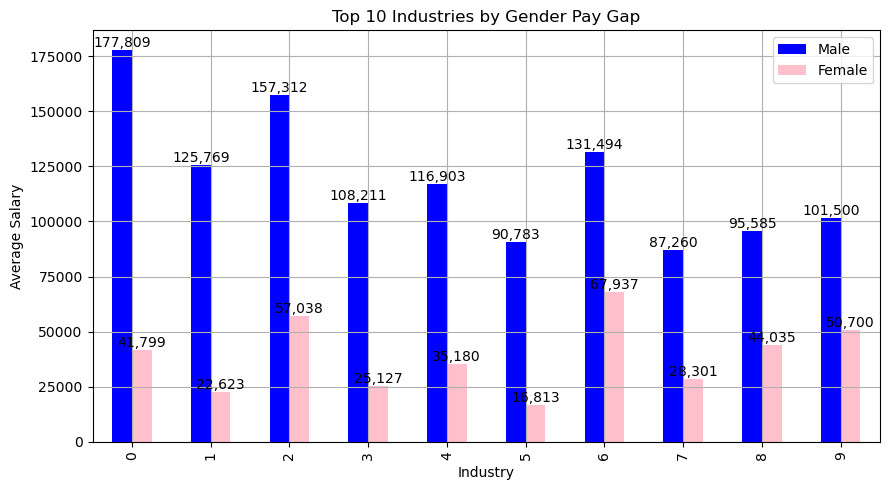

In [21]:
# Group data by industry and gender, and calculate the mean income wage
industries = (combined_df
              .groupBy('ind', 'sex_1')
              .agg(F.mean('incwage').alias('avg_income'))
              .groupBy('ind')
              .pivot('sex_1')
              .agg(F.first('avg_income')))

#Calculate the gender pay gap (difference between male and female average salary)
industries = industries.withColumn('pay_gap', industries['male'] - industries['female'])

#Sort the industries by pay gap and select the top 10
top_10_industries = industries.orderBy('pay_gap', ascending=False).limit(10)

#Collect the data for plotting
top_10_industries_pd = top_10_industries.toPandas()

#Plot the top 10 industries with a bar chart
ax = top_10_industries_pd[['male', 'female']].plot(kind='bar', stacked=False, figsize=(9, 5), color=['blue', 'pink'])

# Adding data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', rotation=0)

# Add labels and title
plt.title('Top 10 Industries by Gender Pay Gap')
plt.xlabel('Industry')
plt.ylabel('Average Salary')
plt.legend(['Male', 'Female'], loc='upper right')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [22]:
#Group by industry and gender, and calculate the average salary
grouped_data = (combined_df
                .groupBy('ind', 'sex_1')
                .agg(F.mean('incwage').alias('avg_incwage')))

# Pivot the DataFrame to get a wide format with genders as columns
grouped_data = grouped_data.groupBy('ind').pivot('sex_1', ['male', 'female']).agg(F.first('avg_incwage'))

#Calculate the pay gap (male salary - female salary)
grouped_data = grouped_data.withColumn('pay_gap', grouped_data['male'] - grouped_data['female'])

#Sort by the largest pay gap and select the top 10
top_10_industries = grouped_data.sort('pay_gap', ascending=False).limit(10)

#Convert to Pandas DataFrame for plotting if needed
top_10_industries_pd = top_10_industries.toPandas()

# Plotting

fig = go.Figure()

# Add male salaries
fig.add_trace(go.Bar(
    x=top_10_industries_pd['ind'], 
    y=top_10_industries_pd['male'], 
    name='Male Salary',
    marker_color='blue',
    hovertemplate='Industry: %{x}<br>Male Salary: %{y}<extra></extra>'
))

# Add female salaries
fig.add_trace(go.Bar(
    x=top_10_industries_pd['ind'], 
    y=top_10_industries_pd['female'], 
    name='Female Salary',
    marker_color='pink',
    hovertemplate='Industry: %{x}<br>Female Salary: %{y}<extra></extra>'
))

# Customize layout
fig.update_layout(
    title='Top 10 Industries by Gender Pay Gap',
    xaxis_title='Industry',
    yaxis_title='Average Salary',
    barmode='group',
    hovermode='x unified',
    width=950,  
    height=550
)

# Show plot
fig.show()

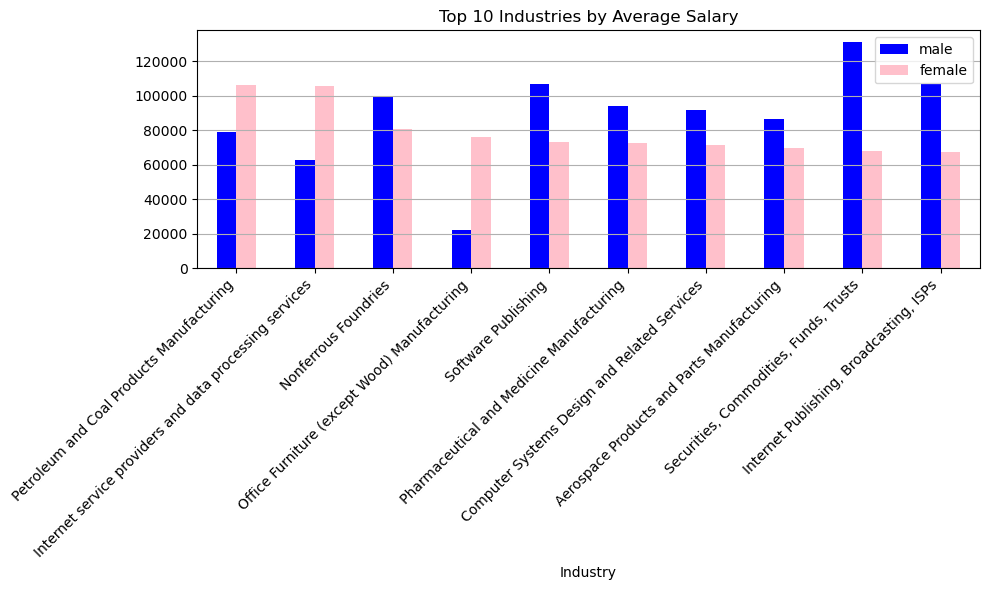

                                                    index         female  \
ind                                                                        
Petroleum and Coal Products Manufacturing             501  106250.000000   
Internet service providers and data processing ...    362  105894.400000   
Nonferrous Foundries                                  150   80894.356688   
Office Furniture (except Wood) Manufacturing          492   76135.181818   
Software Publishing                                   611   73356.338710   
Pharmaceutical and Medicine Manufacturing             391   72755.410188   
Computer Systems Design and Related Services          633   71781.144197   
Aerospace Products and Parts Manufacturing            251   69574.243590   
Securities, Commodities, Funds, Trusts                293   67937.390402   
Internet Publishing, Broadcasting, ISPs               352   67730.160000   

                                                             male  \
ind               

In [23]:
industry_mapping = {
    '7970': 'Offices of Physicians',
    '7270': 'Legal Services',
    '893': 'Office Furniture (except Wood) Manufacturing',
    '6490': 'Software Publishing',
    '2190': 'Pharmaceutical and Medicine Manufacturing',
    '7380': 'Computer Systems Design and Related Services',
    '6970': 'Securities, Commodities, Funds, Trusts',
    '3590': 'Aerospace Products and Parts Manufacturing',
    '6870': 'Banking and Related Activities',
    '3360': 'Nonferrous Foundries',
    '6672': 'Internet Publishing, Broadcasting, ISPs',
    '480': 'Petroleum and Coal Products Manufacturing',
    '6692': 'Internet service providers and data processing services',
}

# Group by industry and gender, and calculate the average salary
industry_income = (combined_df
                   .groupBy('ind', 'sex_1')
                   .agg(F.mean('incwage').alias('mean_income')))

# Pivot the DataFrame to get separate columns for Male and Female
industry_income_pivot = industry_income.groupBy('ind').pivot('sex_1').agg(F.mean('mean_income'))

# Handle missing values (if necessary)
industry_income_pivot = industry_income_pivot.fillna(0)

# Convert to Pandas DataFrame for plotting
industry_income_pd = industry_income_pivot.toPandas()

# Reset index to make 'ind' a column
industry_income_pd.reset_index(inplace=True)

# Map industry codes to descriptive names
industry_income_pd['ind'] = industry_income_pd['ind'].replace(industry_mapping)

# Calculate average salary for male and female and add a column for the difference
industry_income_pd['Income Difference'] = industry_income_pd['female'] - industry_income_pd['male']

# Sort the DataFrame by average female salary and get the top 10
top_10_industries = industry_income_pd.sort_values(by='female', ascending=False).head(10)

# Plotting the top 10 industries
top_10_industries.set_index('ind', inplace=True)  # Set 'ind' as index for better plotting
top_10_industries[['male', 'female']].plot(kind='bar', figsize=(10, 6), color=['blue', 'pink'])

# Add labels and title
plt.title('Top 10 Industries by Average Salary')
plt.xlabel('Industry')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

# Display the top 10 DataFrame
print(top_10_industries)

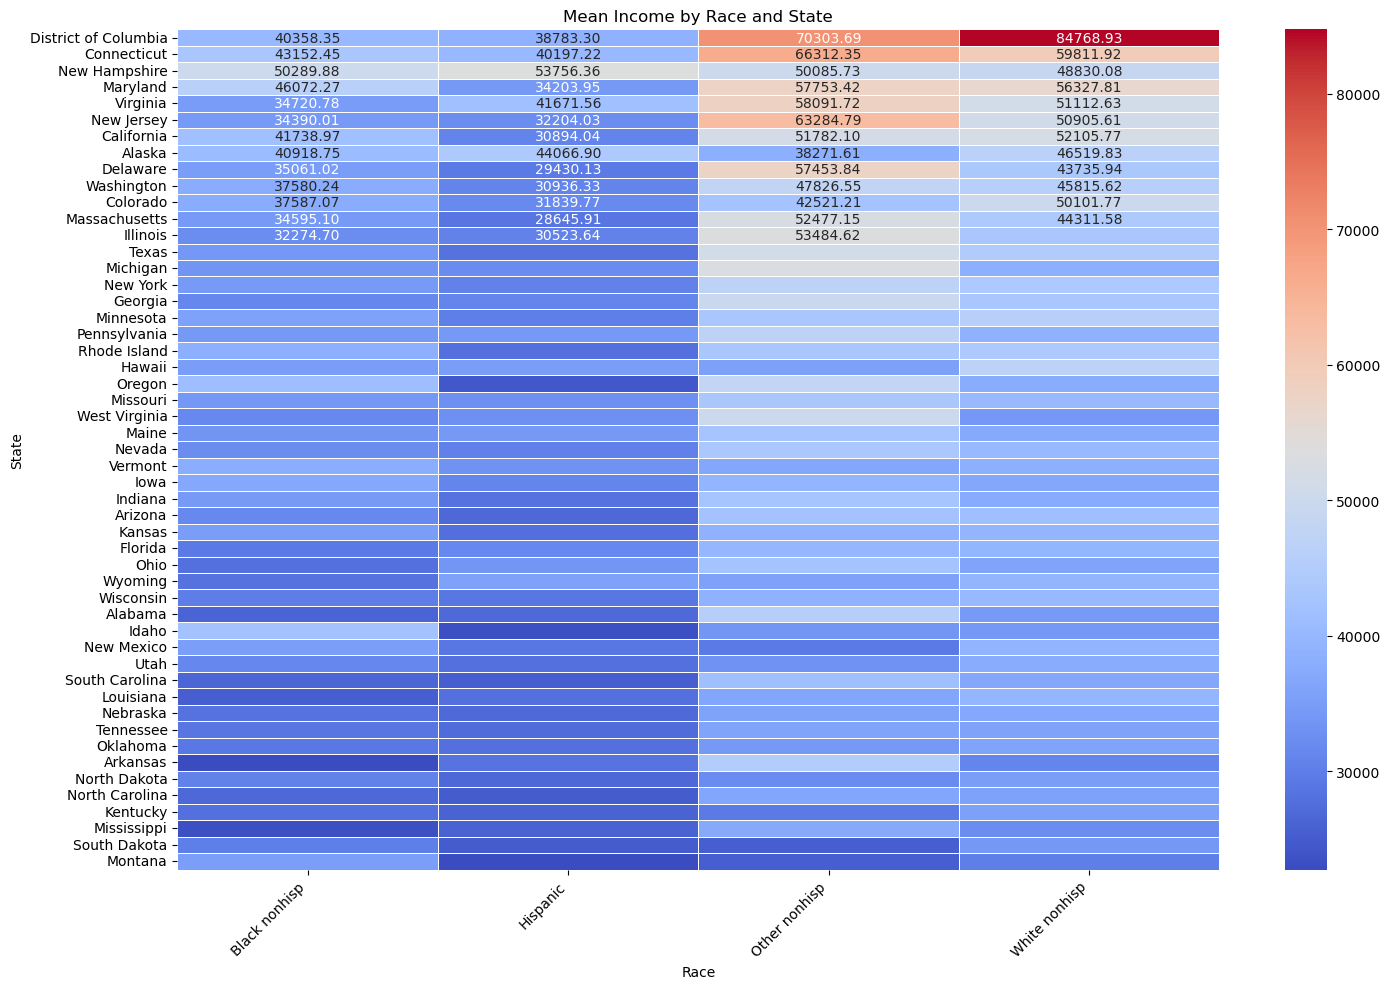

In [24]:
# Group the data to calculate mean income by state and race
mean_data = combined_df.groupBy('state name', 'race_1').agg(F.mean('incwage').alias('mean')).toPandas()

# Pivot the data to get mean income by race and state
heatmap_data = mean_data.pivot(index='state name', columns='race_1', values='mean')

# Calculate the overall mean income per state (mean across all races)
heatmap_data['Overall_Mean'] = heatmap_data.mean(axis=1)

# Sort the states by the overall mean income in descending order
heatmap_data_sorted = heatmap_data.sort_values(by='Overall_Mean', ascending=False).drop(columns='Overall_Mean')

# Create a heatmap with annotations
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_sorted, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
plt.title('Mean Income by Race and State')
plt.ylabel('State')
plt.xlabel('Race')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [25]:
# Group the data by industry ('ind') and sex ('sex_1'), then calculate mean income ('incwage')
industry_income = combined_df.groupBy('ind', 'sex_1').agg(F.mean('incwage').alias('mean_incwage'))

# Pivot the DataFrame to reshape it
industry_income_pivot = industry_income.groupBy('ind').pivot('sex_1', ['male', 'female']).agg(F.first('mean_incwage'))

# Rename columns for clarity
industry_income_pivot = industry_income_pivot.withColumnRenamed('Male', 'Male').withColumnRenamed('Female', 'Female')

# Fill NaNs with median income for each group
median_male = industry_income_pivot.select(F.expr('percentile_approx(male, 0.5)').alias('median')).collect()[0]['median']
median_female = industry_income_pivot.select(F.expr('percentile_approx(female, 0.5)').alias('median')).collect()[0]['median']

industry_income_pivot = industry_income_pivot.fillna({'Male': median_male, 'Female': median_female})

# Calculate Income Difference
industry_income_pivot = industry_income_pivot.withColumn('Income Difference', industry_income_pivot['Female'] - industry_income_pivot['Male'])
industry_income_pivot = industry_income_pivot.withColumn('abs_diff', F.abs(industry_income_pivot['Income Difference']))

# Check for remaining NaN values
if industry_income_pivot.filter(F.isnan('abs_diff') | F.isnan('Income Difference')).count() > 0:
    print("NaN values found in 'abs_diff' or 'Income Difference'. Filling with 0.")
    industry_income_pivot = industry_income_pivot.fillna({'Income Difference': 0})

# Using Plotly as before
import plotly.express as px

# Create a scatter plot with Plotly
fig = px.scatter(industry_income_pivot.toPandas(), x='Male', y='Female', 
                 size='abs_diff', color='Income Difference', 
                 hover_data=['ind', 'Male', 'Female', 'Income Difference'],
                 title='Gender Pay Gap Across Industries',
                 labels={'Male': 'Average Male Income', 'Female': 'Average Female Income'},
                 color_continuous_scale='Viridis',
                 size_max=100)

# Add line for equal pay
fig.add_shape(type='line', x0=0, y0=0, x1=industry_income_pivot.select(F.max('Male')).first()[0], 
              y1=industry_income_pivot.select(F.max('Female')).first()[0], 
              line=dict(color='gray', dash='dash'))

# Show the interactive plot
fig.show()

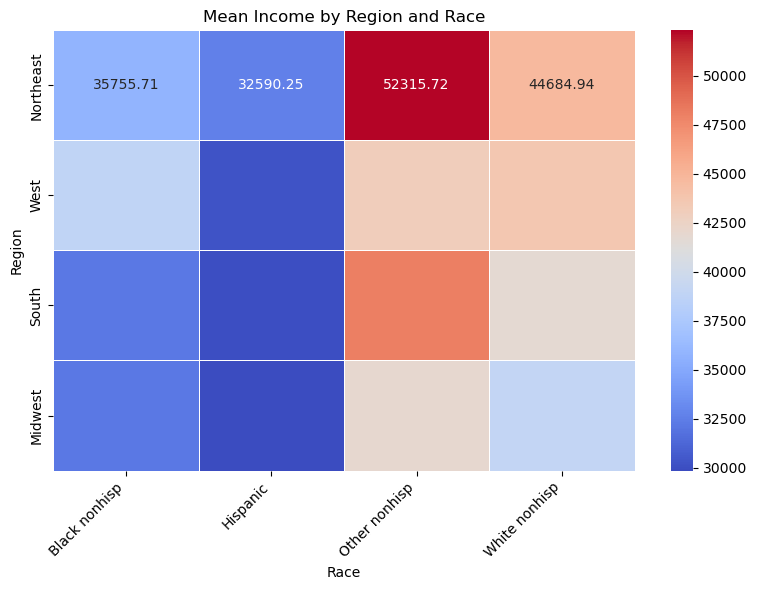

In [26]:
# Group the data by 'region' and 'race_1', calculate the mean income ('incwage')
grouped_data = combined_df.groupBy('region_1', 'race_1').agg(F.mean('incwage').alias('mean_incwage'))

# Convert the grouped data back to Pandas DataFrame for visualization
mean_data = grouped_data.toPandas()

# Pivot the data to get mean income by region and state
heatmap_data = mean_data.pivot(index='region_1', columns='race_1', values='mean_incwage')

# Calculate the overall mean income per state (mean across all races)
heatmap_data['Overall_Mean'] = heatmap_data.mean(axis=1)

# Sort the states by the overall mean income in descending order
heatmap_data_sorted = heatmap_data.sort_values(by='Overall_Mean', ascending=False).drop(columns='Overall_Mean')


# Create a heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data_sorted, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
plt.title('Mean Income by Region and Race')
plt.ylabel('Region')
plt.xlabel('Race')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


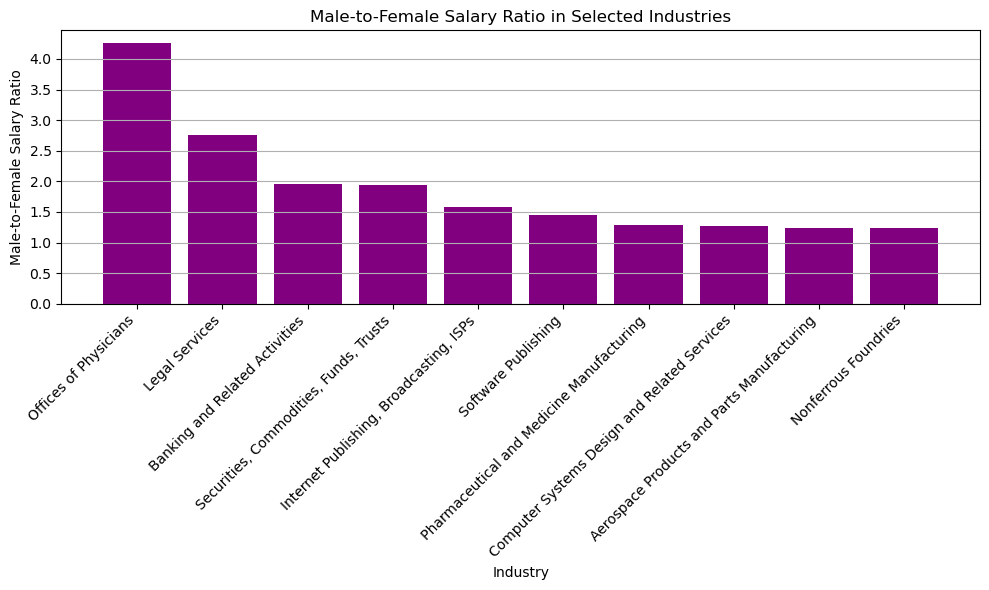

                                         ind_name  male_to_female_ratio
181                         Offices of Physicians              4.253908
505                                Legal Services              2.758037
631                Banking and Related Activities              1.959441
293        Securities, Commodities, Funds, Trusts              1.935511
352       Internet Publishing, Broadcasting, ISPs              1.578038
611                           Software Publishing              1.454098
391     Pharmaceutical and Medicine Manufacturing              1.292788
633  Computer Systems Design and Related Services              1.277992
251    Aerospace Products and Parts Manufacturing              1.242501
150                          Nonferrous Foundries              1.232819


In [27]:
# Define the mapping of industry codes to descriptive names
industry_mapping = {
    '7970': 'Offices of Physicians',
    '7270': 'Legal Services',
    '893': 'Office Furniture (except Wood) Manufacturing',
    '6490': 'Software Publishing',
    '2190': 'Pharmaceutical and Medicine Manufacturing',
    '7380': 'Computer Systems Design and Related Services',
    '6970': 'Securities, Commodities, Funds, Trusts',
    '3590': 'Aerospace Products and Parts Manufacturing',
    '6870': 'Banking and Related Activities',
    '3360': 'Nonferrous Foundries',
    '6672': 'Internet Publishing, Broadcasting, ISPs',
    '480': 'Petroleum and Coal Products Manufacturing'
}

# Group by industry and gender, and calculate the average salary
industry_income = (combined_df
                   .groupBy('ind', 'sex_1')
                   .agg(F.mean('incwage').alias('mean_income')))

# Pivot the DataFrame to get separate columns for Male and Female
industry_income_pivot = industry_income.groupBy('ind').pivot('sex_1').agg(F.mean('mean_income'))

# Handle missing values (if necessary)
industry_income_pivot = industry_income_pivot.fillna(0)

# Create a new column for industry names based on mapping
industry_income_pivot = industry_income_pivot.withColumn('ind_name', 
    F.when(F.col('ind') == '7970', 'Offices of Physicians')
    .when(F.col('ind') == '7270', 'Legal Services')
    .when(F.col('ind') == '893', 'Office Furniture (except Wood) Manufacturing')
    .when(F.col('ind') == '6490', 'Software Publishing')
    .when(F.col('ind') == '2190', 'Pharmaceutical and Medicine Manufacturing')
    .when(F.col('ind') == '7380', 'Computer Systems Design and Related Services')
    .when(F.col('ind') == '6970', 'Securities, Commodities, Funds, Trusts')
    .when(F.col('ind') == '3590', 'Aerospace Products and Parts Manufacturing')
    .when(F.col('ind') == '6870', 'Banking and Related Activities')
    .when(F.col('ind') == '3360', 'Nonferrous Foundries')
    .when(F.col('ind') == '6672', 'Internet Publishing, Broadcasting, ISPs')
    .when(F.col('ind') == '480', 'Petroleum and Coal Products Manufacturing')
    .otherwise(F.col('ind')))

# Calculate the male-to-female salary ratio
industry_income_pivot = industry_income_pivot.withColumn('male_to_female_ratio',
    F.when(F.col('female') > 0, F.col('male') / F.col('female'))
    .otherwise(0)
)

# Convert to Pandas DataFrame for better visualization
industry_income_pd = industry_income_pivot.toPandas()

# Select only industries of interest
industries_of_interest = list(industry_mapping.keys())
industry_income_filtered = industry_income_pd[industry_income_pd['ind'].isin(industries_of_interest)]

# Sort the DataFrame by male-to-female ratio and get the top 10
top_10_industries = industry_income_filtered.sort_values(by='male_to_female_ratio', ascending=False).head(10)

# Plotting the top industries' male-to-female salary ratios
plt.figure(figsize=(10, 6))
plt.bar(top_10_industries['ind_name'], top_10_industries['male_to_female_ratio'], color='purple')

# Add labels and title
plt.title('Male-to-Female Salary Ratio in Selected Industries')
plt.xlabel('Industry')
plt.ylabel('Male-to-Female Salary Ratio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

# Display the top 10 DataFrame
print(top_10_industries[['ind_name', 'male_to_female_ratio']])

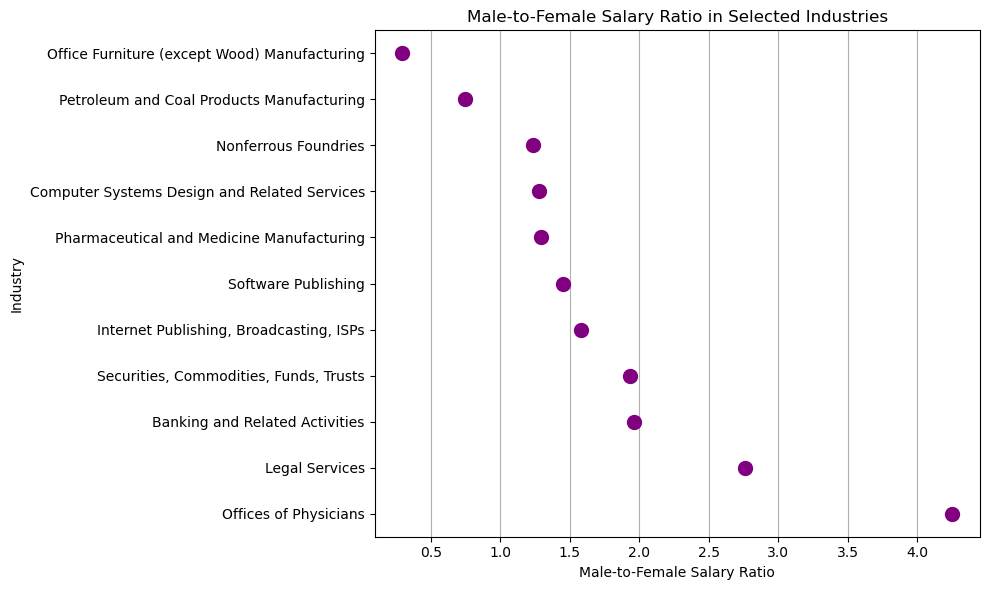

                                         ind_name  male_to_female_ratio
181                         Offices of Physicians              4.253908
505                                Legal Services              2.758037
631                Banking and Related Activities              1.959441
293        Securities, Commodities, Funds, Trusts              1.935511
352       Internet Publishing, Broadcasting, ISPs              1.578038
611                           Software Publishing              1.454098
391     Pharmaceutical and Medicine Manufacturing              1.292788
633  Computer Systems Design and Related Services              1.277992
150                          Nonferrous Foundries              1.232819
501     Petroleum and Coal Products Manufacturing              0.743624
492  Office Furniture (except Wood) Manufacturing              0.293436


In [28]:
# Calculate the male-to-female salary ratio
industry_income_pivot = industry_income_pivot.withColumn(
    'male_to_female_ratio',
    F.when(F.col('female') > 0, F.col('male') / F.col('female'))
    .otherwise(0)
)

# Convert to Pandas DataFrame for plotting
industry_income_pd = industry_income_pivot.toPandas()

# Define the industry names mapping
industry_mapping = {
    '7970': 'Offices of Physicians',
    '7270': 'Legal Services',
    '893': 'Office Furniture (except Wood) Manufacturing',
    '6490': 'Software Publishing',
    '2190': 'Pharmaceutical and Medicine Manufacturing',
    '7380': 'Computer Systems Design and Related Services',
    '6970': 'Securities, Commodities, Funds, Trusts',
    '3590': 'Aerospace Products and Parts Manufacturing',
    '6870': 'Banking and Related Activities',
    '3360': 'Nonferrous Foundries',
    '6672': 'Internet Publishing, Broadcasting, ISPs',
    '480': 'Petroleum and Coal Products Manufacturing'
}

# Map industry codes to names
industry_income_pd['ind_name'] = industry_income_pd['ind'].replace(industry_mapping)

# List of industries to display
selected_industries = [
    'Offices of Physicians', 
    'Legal Services', 
    'Office Furniture (except Wood) Manufacturing', 
    'Software Publishing', 
    'Pharmaceutical and Medicine Manufacturing', 
    'Computer Systems Design and Related Services', 
    'Securities, Commodities, Funds, Trusts', 
    'Banking and Related Activities', 
    'Nonferrous Foundries', 
    'Internet Publishing, Broadcasting, ISPs', 
    'Petroleum and Coal Products Manufacturing'
]

# Filter the DataFrame for only the selected industries
filtered_industries = industry_income_pd[industry_income_pd['ind_name'].isin(selected_industries)]

# Sort the filtered DataFrame by the male_to_female_ratio
filtered_industries = filtered_industries.sort_values(by='male_to_female_ratio', ascending=False)

# Create a dot plot
plt.figure(figsize=(10, 6))
plt.plot(filtered_industries['male_to_female_ratio'], filtered_industries['ind_name'], 'o', color='purple', markersize=10)

# Add labels and title
plt.title('Male-to-Female Salary Ratio in Selected Industries')
plt.xlabel('Male-to-Female Salary Ratio')
plt.ylabel('Industry')
plt.grid(axis='x')

# Show the plot
plt.tight_layout()
plt.show()

# Display the filtered DataFrame
print(filtered_industries[['ind_name', 'male_to_female_ratio']])

In [29]:
# Select columns for updated DF
updated_df = combined_df.select(
    'year',
    'state name',
    'region_1',
    'age',
    'sex_1',
    'race_1',
    'martial status',
    'occ',
    'incwage')

# Show updated DF
updated_df.show(5, truncate=False)

+----+--------------------+---------+---+-----+-------------+-----------------------+---+-------+
|year|state name          |region_1 |age|sex_1|race_1       |martial status         |occ|incwage|
+----+--------------------+---------+---+-----+-------------+-----------------------+---+-------+
|1981|Virginia            |South    |38 |male |Other nonhisp|Married, spouse present|245|17000.0|
|1981|Vermont             |Northeast|58 |male |White nonhisp|Married, spouse present|470|19000.0|
|1981|Utah                |West     |35 |male |White nonhisp|Married, spouse present|715|21000.0|
|1981|Illinois            |Midwest  |33 |male |White nonhisp|Divorced               |485|19740.0|
|1981|District of Columbia|South    |45 |male |Black nonhisp|Never mar              |13 |46000.0|
+----+--------------------+---------+---+-----+-------------+-----------------------+---+-------+
only showing top 5 rows



In [30]:
# Rename columns and update DF
updated_df = updated_df.withColumnRenamed('martial status', 'Marital Status')
updated_df = updated_df.withColumnRenamed('year', 'Year')
updated_df = updated_df.withColumnRenamed('state_name', 'State Name')
updated_df = updated_df.withColumnRenamed('region_1', 'Region')
updated_df = updated_df.withColumnRenamed('sex_1', 'Sex')
updated_df = updated_df.withColumnRenamed('race_1', 'Race')
updated_df = updated_df.withColumnRenamed('occ', 'Occupation Code')
updated_df = updated_df.withColumnRenamed('incwage', 'Wage')
updated_df = updated_df.withColumnRenamed('age','Age')

# Show updated DF
updated_df.show(5, truncate=False)

+----+--------------------+---------+---+----+-------------+-----------------------+---------------+-------+
|Year|state name          |Region   |Age|Sex |Race         |Marital Status         |Occupation Code|Wage   |
+----+--------------------+---------+---+----+-------------+-----------------------+---------------+-------+
|1981|Virginia            |South    |38 |male|Other nonhisp|Married, spouse present|245            |17000.0|
|1981|Vermont             |Northeast|58 |male|White nonhisp|Married, spouse present|470            |19000.0|
|1981|Utah                |West     |35 |male|White nonhisp|Married, spouse present|715            |21000.0|
|1981|Illinois            |Midwest  |33 |male|White nonhisp|Divorced               |485            |19740.0|
|1981|District of Columbia|South    |45 |male|Black nonhisp|Never mar              |13             |46000.0|
+----+--------------------+---------+---+----+-------------+-----------------------+---------------+-------+
only showing top 5 

In [31]:
# Define age bins and labels
bins = [25, 30, 35, 40, 45, 50, 55, 60, 64]
labels = ['25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-64']

# Create age bins in updated DF
age_bins_df = updated_df.withColumn(
    'Age_Bin',
    F.when((F.col('Age') >= 25) & (F.col('Age') < 30), labels[0])
    .when((F.col('Age') >= 30) & (F.col('Age') < 35), labels[1])
    .when((F.col('Age') >= 35) & (F.col('Age') < 40), labels[2])
    .when((F.col('Age') >= 40) & (F.col('Age') < 45), labels[3])
    .when((F.col('Age') >= 45) & (F.col('Age') < 50), labels[4])
    .when((F.col('Age') >= 50) & (F.col('Age') < 55), labels[5])
    .when((F.col('Age') >= 55) & (F.col('Age') < 60), labels[6])
    .when((F.col('Age') >= 60) & (F.col('Age') <= 64), labels[7]))

# Show updated DF with the age bin
age_bins_df.show(5)

+----+--------------------+---------+---+----+-------------+--------------------+---------------+-------+-------+
|Year|          state name|   Region|Age| Sex|         Race|      Marital Status|Occupation Code|   Wage|Age_Bin|
+----+--------------------+---------+---+----+-------------+--------------------+---------------+-------+-------+
|1981|            Virginia|    South| 38|male|Other nonhisp|Married, spouse p...|            245|17000.0|  35-40|
|1981|             Vermont|Northeast| 58|male|White nonhisp|Married, spouse p...|            470|19000.0|  55-60|
|1981|                Utah|     West| 35|male|White nonhisp|Married, spouse p...|            715|21000.0|  35-40|
|1981|            Illinois|  Midwest| 33|male|White nonhisp|            Divorced|            485|19740.0|  30-35|
|1981|District of Columbia|    South| 45|male|Black nonhisp|           Never mar|             13|46000.0|  45-50|
+----+--------------------+---------+---+----+-------------+--------------------+-------

<Figure size 1500x800 with 0 Axes>

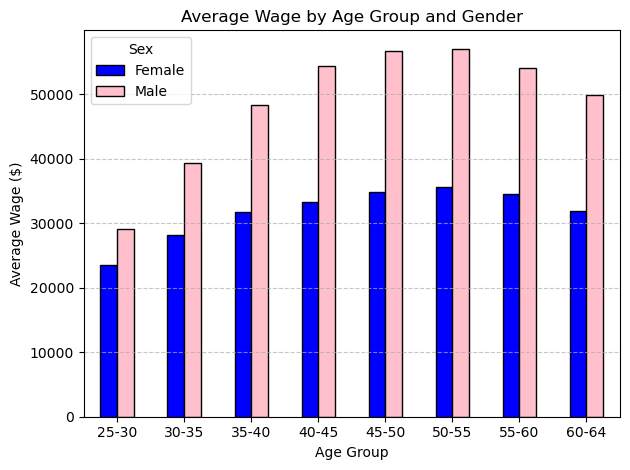

In [32]:
# Group the data by age and sex and calculate average wage
avg_wage_by_region = age_bins_df.groupBy('Age_Bin', 'Sex').agg(avg('Wage').alias('Average_Wage'))

# Convert to pandas DF
avg_wage_by_region_pd = avg_wage_by_region.toPandas().pivot(index='Age_Bin', columns='Sex', values='Average_Wage')

# Create plot
plt.figure(figsize=(15, 8))
avg_wage_by_region_pd.plot(kind='bar', color=['blue', 'pink'], edgecolor='black')

plt.title('Average Wage by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Average Wage ($)')
plt.xticks(rotation=0)
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.grid(axis='y', linestyle='--', alpha=0.7) 

# Show plot
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

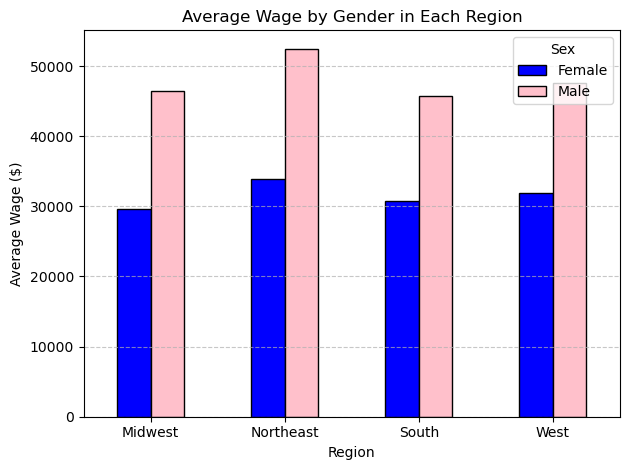

In [33]:
# Group data by region and sex and calculate average wage
avg_wage_by_region = updated_df.groupBy('Region', 'Sex').agg(avg('Wage').alias('Average_Wage'))

# Convert to pandas DF
avg_wage_by_region_pd = avg_wage_by_region.toPandas().pivot(index='Region', columns='Sex', values='Average_Wage')

# Create plot
plt.figure(figsize=(12, 8))
avg_wage_by_region_pd.plot(kind='bar', color=['blue', 'pink'], edgecolor='black')

plt.title('Average Wage by Gender in Each Region')
plt.xlabel('Region')
plt.ylabel('Average Wage ($)')
plt.xticks(rotation=0)
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.grid(axis='y', linestyle='--', alpha=0.7) 

# Show plot
plt.tight_layout()
plt.show()

<Figure size 800x1200 with 0 Axes>

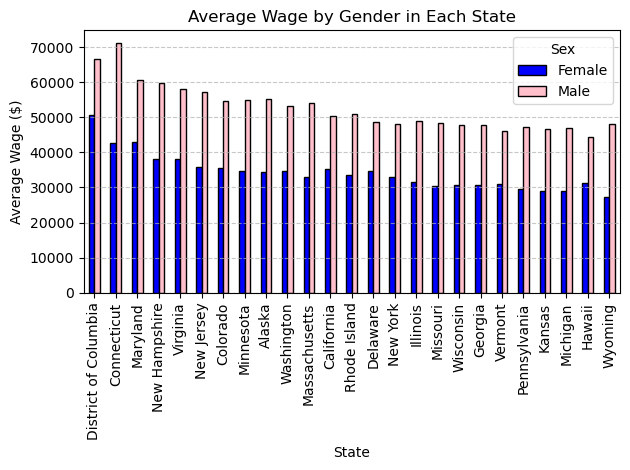

In [34]:
# Group the data by state and sex and calculate average wage
avg_wage_by_state1 = updated_df.groupBy('state name', 'Sex').agg(avg('Wage').alias('Average_Wage'))

# Convert to pandas DF
avg_wage_by_state_pd1 = avg_wage_by_state1.toPandas().pivot(index='state name', columns='Sex', values='Average_Wage')

# Sort by average wage for the top 25 states
top_states = avg_wage_by_state_pd1.mean(axis=1).nlargest(25).index
top_avg_wage_by_state_pd = avg_wage_by_state_pd1.loc[top_states]

# Create plot
plt.figure(figsize=(8, 12))
top_avg_wage_by_state_pd.plot(kind='bar', color=['blue', 'pink'], edgecolor='black')

plt.title('Average Wage by Gender in Each State')
plt.xlabel('State')
plt.ylabel('Average Wage ($)')
plt.xticks(rotation=90)
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [35]:
occupation_counts_by_sex = updated_df.groupby(['Sex', 'Occupation Code']).count()
sorted_counts = occupation_counts_by_sex.orderBy('count', ascending=False)
sorted_counts.show(5)

+------+---------------+-----+
|   Sex|Occupation Code|count|
+------+---------------+-----+
|female|           5700| 5414|
|  male|           9130| 4918|
|female|           2310| 4883|
|  male|            430| 3143|
|female|           3600| 2919|
+------+---------------+-----+
only showing top 5 rows



In [36]:
# top 25 results
top_counts = sorted_counts.orderBy('count', ascending=False).limit(25)

# Convert to pandas DF
top_counts_pd = top_counts.toPandas()
top_counts_pd = top_counts_pd.sort_values(by='count', ascending=False)

top_counts_pd.head()

,Sex,Occupation Code,count
0,female,5700,5414
1,male,9130,4918
2,female,2310,4883
3,male,430,3143
4,female,3600,2919


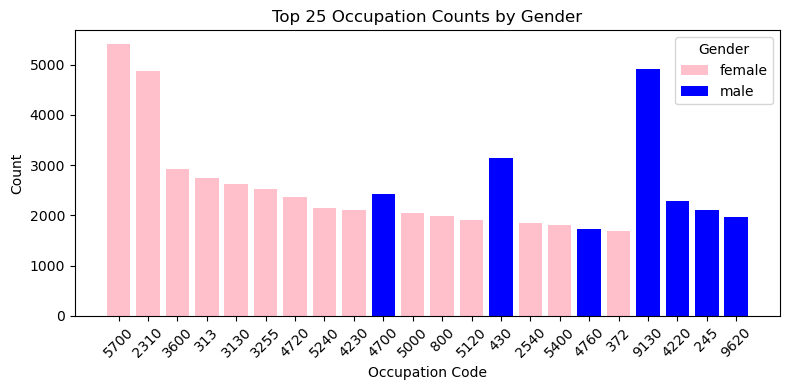

In [37]:
# Create plot
plt.figure(figsize=(8, 4))
for sex in top_counts_pd['Sex'].unique():
    subset = top_counts_pd[top_counts_pd['Sex'] == sex]
    plt.bar(subset['Occupation Code'].astype(str), subset['count'], label=sex, color='blue' if sex == 'male' else 'pink')
    
plt.xlabel('Occupation Code')
plt.ylabel('Count')
plt.title('Top 25 Occupation Counts by Gender')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()

# Show plot
plt.show()

In [38]:
sex_count = updated_df.groupby(['Sex']).count()
sex_count.show()

+------+------+
|   Sex| count|
+------+------+
|female|168376|
|  male|175911|
+------+------+



In [39]:
occupation_counts_overall = updated_df.groupby(['Occupation Code']).count()
sorted_counts = occupation_counts_overall.orderBy('count', ascending=False)
sorted_counts.show(5)

+---------------+-----+
|Occupation Code|count|
+---------------+-----+
|           2310| 6010|
|           5700| 5602|
|           9130| 5161|
|            430| 5009|
|           4700| 4484|
+---------------+-----+
only showing top 5 rows



<Figure size 1200x800 with 0 Axes>

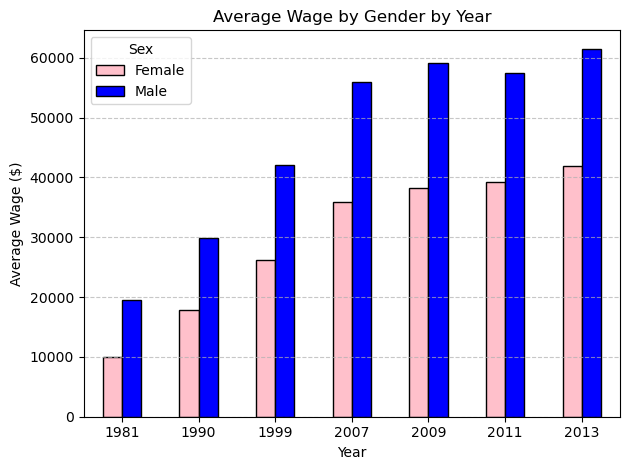

In [40]:
# Group the data by year and sex and calculate average wage
avg_wage_by_year = updated_df.groupBy('Year', 'Sex').agg(avg('Wage').alias('Average_Wage'))

# Convert to pandas DF
avg_wage_by_year_pd = avg_wage_by_year.toPandas().pivot(index='Year', columns='Sex', values='Average_Wage')

# Create plot
plt.figure(figsize=(12, 8))
avg_wage_by_year_pd.plot(kind='bar', color=['pink', 'blue'], edgecolor='black')

plt.title('Average Wage by Gender by Year')
plt.xlabel('Year')
plt.ylabel('Average Wage ($)')
plt.xticks(rotation=0)
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.grid(axis='y', linestyle='--', alpha=0.7) 

# Show plot
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

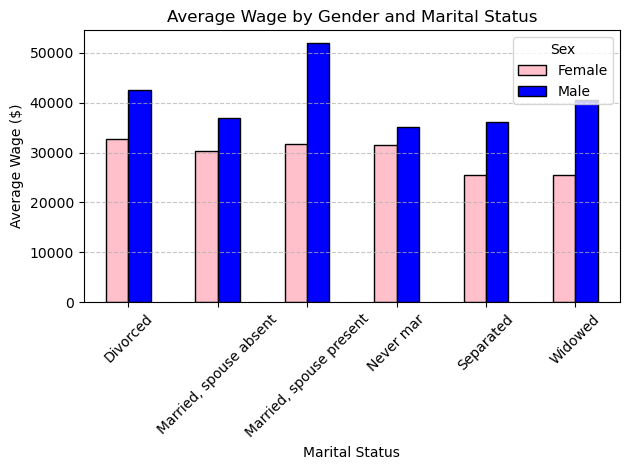

In [41]:
# Group the data by marital status and sex and calculate average wage
avg_wage_by_marital = updated_df.groupBy('Marital Status', 'Sex').agg(avg('Wage').alias('Average_Wage'))

# Convert to pandas DF
avg_wage_by_marital_pd = avg_wage_by_marital.toPandas().pivot(index='Marital Status', columns='Sex', values='Average_Wage')

# Create plot
plt.figure(figsize=(12, 8))
avg_wage_by_marital_pd.plot(kind='bar', color=['pink', 'blue'], edgecolor='black')

plt.title('Average Wage by Gender and Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Average Wage ($)')
plt.xticks(rotation=45)
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.grid(axis='y', linestyle='--', alpha=0.7) 

# Show plot
plt.tight_layout()
plt.show()

<Figure size 800x1200 with 0 Axes>

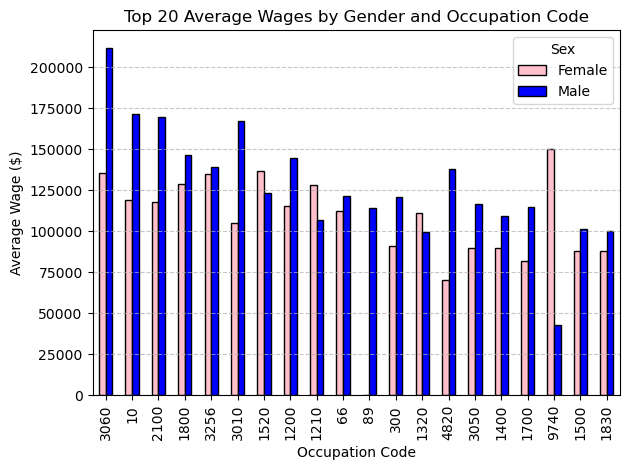

In [42]:
# Group data by occupation code and Sex and calculate average wage
avg_wage_by_occupation = updated_df.groupBy('Occupation Code', 'Sex').agg(avg('Wage').alias('Average_Wage'))

# Convert to pandas DataFrame for plotting
avg_wage_by_occupation_pd = avg_wage_by_occupation.toPandas().pivot(index='Occupation Code', columns='Sex', values='Average_Wage')

# Sort by average wage and get the top 20 occupations
top_occupation = avg_wage_by_occupation_pd.mean(axis=1).nlargest(20).index
top_avg_wage_by_occupation_pd = avg_wage_by_occupation_pd.loc[top_occupation]

# Create plot
plt.figure(figsize=(8, 12))
top_avg_wage_by_occupation_pd.plot(kind='bar', color=['pink', 'blue'], edgecolor='black')

plt.title('Top 20 Average Wages by Gender and Occupation Code')
plt.xlabel('Occupation Code')
plt.ylabel('Average Wage ($)')
plt.xticks(rotation=90)
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

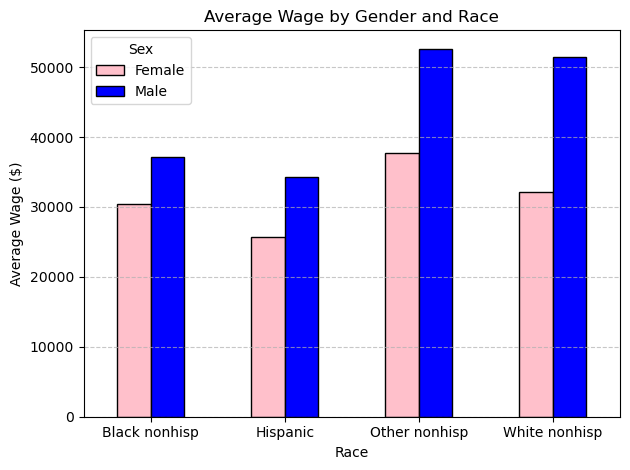

In [43]:
# Group data by race and sex and calculate average wages
avg_wage_by_race = updated_df.groupBy('Race', 'Sex').agg(avg('Wage').alias('Average_Wage'))

# Convert to pandas DF
avg_wage_by_race_pd = avg_wage_by_race.toPandas().pivot(index='Race', columns='Sex', values='Average_Wage')

# Create plot
plt.figure(figsize=(12, 8))
avg_wage_by_race_pd.plot(kind='bar', color=['pink', 'blue'], edgecolor='black')

plt.title('Average Wage by Gender and Race')
plt.xlabel('Race')
plt.ylabel('Average Wage ($)')
plt.xticks(rotation=0)
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.grid(axis='y', linestyle='--', alpha=0.7) 

# Show plot
plt.tight_layout()
plt.show()

In [44]:
# Average wages by Year and Sex
avg_wage_by_gender_year = (updated_df.groupBy('Year', 'Sex').agg(F.avg('Wage').alias('Average_Wage')))

In [45]:
# Convert to pandas DF
avg_wage_by_gender_year_pd = avg_wage_by_gender_year.toPandas()

# Pivot DF
avg_wage_pivot = avg_wage_by_gender_year_pd.pivot(index='Year', columns='Sex', values='Average_Wage')

# Calculate wage gap
avg_wage_pivot['Wage_Gap'] = ((avg_wage_pivot['male'] - avg_wage_pivot['female']) / avg_wage_pivot['male']) * 100
avg_wage_pivot

Sex,female,male,Wage_Gap
Year,,,
1981,9898.469764,19466.873890,49.152238
1990,17777.511007,29865.680873,40.475119
1999,26161.166138,42076.207260,37.824324
2007,35925.591945,55940.521887,35.778947
2009,38153.524120,59178.657823,35.528237
2011,39186.030374,57441.479840,31.780953
2013,41906.379635,61496.970138,31.856188


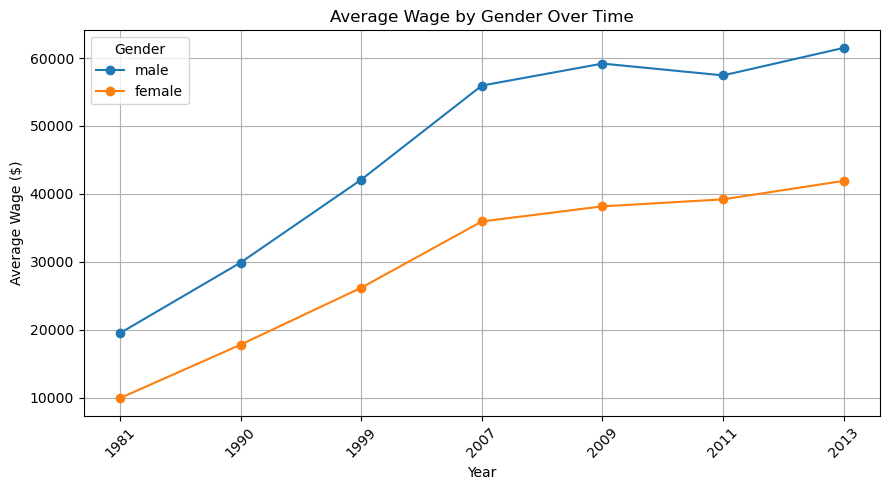

In [46]:
# Plot Chart
plt.figure(figsize=(9, 5))
avg_wage_pivot[['male', 'female']].plot(kind='line', marker='o', ax=plt.gca())
plt.title('Average Wage by Gender Over Time')
plt.xlabel('Year')
plt.ylabel('Average Wage ($)')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Gender')

plt.tight_layout()
plt.show()

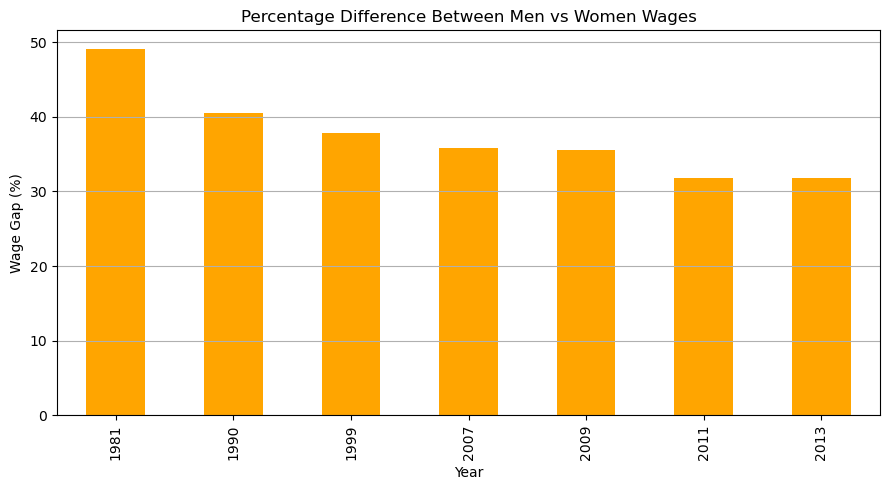

In [47]:
# Plot Chart
plt.figure(figsize=(9, 5))
avg_wage_pivot['Wage_Gap'].plot(kind='bar', color='orange')
plt.title('Percentage Difference Between Men vs Women Wages')
plt.xlabel('Year')
plt.ylabel('Wage Gap (%)')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## Creating a predictive model using Randomforest Regression:

In [48]:
# Creating the Randomforest Regression including all features:

# Calculate the average salary by year, state name, race, age, union type, and marital status
avg_income_data = (
    combined_df
    .groupBy(['year', 'state name', 'race_1', 'age', 'union type', 'martial status', 'sex_1'])
    .agg(F.mean('incwage').alias('avg_income'))  # Calculate average income
)
avg_income_data.show(5)


+----+----------+-------------+---+----------+--------------------+-----+-----------------+
|year|state name|       race_1|age|union type|      martial status|sex_1|       avg_income|
+----+----------+-------------+---+----------+--------------------+-----+-----------------+
|1981|   Wyoming|White nonhisp| 57|      NULL|Married, spouse p...| male|          19600.0|
|1981|  Michigan|White nonhisp| 34|      NULL|            Divorced| male|          13250.0|
|1981|      Ohio|White nonhisp| 37|      NULL|Married, spouse p...| male|20747.91304347826|
|1981|    Nevada|White nonhisp| 58|      NULL|Married, spouse p...| male|          20062.5|
|1981|  Delaware|White nonhisp| 38|      NULL|Married, spouse p...| male|          33617.5|
+----+----------+-------------+---+----------+--------------------+-----+-----------------+
only showing top 5 rows



In [49]:
# Pivot to get male and female average incomes
avg_income_pivot = avg_income_data.groupBy(['year', 'state name', 'race_1', 'age', 'union type', 'martial status']).pivot('sex_1', ['male', 'female']).agg(F.first('avg_income'))
avg_income_pivot.show(5)

+----+----------+-------------+---+--------------------+--------------------+----+-------+
|year|state name|       race_1|age|          union type|      martial status|male| female|
+----+----------+-------------+---+--------------------+--------------------+----+-------+
|1990|  New York|Black nonhisp| 42|                 NIU|Married, spouse p...|NULL|33375.0|
|1990|    Alaska|Other nonhisp| 39|                 NIU|            Divorced|NULL|19027.0|
|1990|  Virginia|White nonhisp| 43|Member of labor u...|Married, spouse p...|NULL|17478.0|
|1990|     Texas|Black nonhisp| 34|   No union coverage|           Separated|NULL|15000.0|
|1990|   Wyoming|White nonhisp| 28|                 NIU|            Divorced|NULL|19500.0|
+----+----------+-------------+---+--------------------+--------------------+----+-------+
only showing top 5 rows



In [50]:
# Calculate pay gap (percentage difference)
avg_income_pivot = avg_income_pivot.withColumn('pay_gap', 
    (avg_income_pivot['male'] - avg_income_pivot['female']) / avg_income_pivot['male'] * 100)

# Order and show final results
avg_income_pivot.orderBy('year', 'state name', 'race_1', 'age', 'union type', 'martial status').show(5)

+----+----------+-------------+---+----------+--------------------+------------------+-------+-----------------+
|year|state name|       race_1|age|union type|      martial status|              male| female|          pay_gap|
+----+----------+-------------+---+----------+--------------------+------------------+-------+-----------------+
|1981|   Alabama|Black nonhisp| 25|      NULL|Married, spouse p...|           12440.0|8172.25|34.30667202572347|
|1981|   Alabama|Black nonhisp| 25|      NULL|           Never mar|           14000.0| 4000.0|71.42857142857143|
|1981|   Alabama|Black nonhisp| 25|      NULL|           Separated|              NULL| 2075.0|             NULL|
|1981|   Alabama|Black nonhisp| 26|      NULL|Married, spouse p...|10093.666666666666| 2600.0|  74.241273405766|
|1981|   Alabama|Black nonhisp| 27|      NULL|Married, spouse a...|              NULL|12000.0|             NULL|
+----+----------+-------------+---+----------+--------------------+------------------+-------+--

In [51]:
# Convert to Pandas for scikit-learn model
avg_income_pandas = avg_income_pivot.orderBy('year').toPandas()
avg_income_pandas.head()

,year,state name,race_1,age,union type,martial status,male,female,pay_gap
0,1981,California,White nonhisp,48,None,"Married, spouse present",27102.545455,11746.333333,56.659667
1,1981,Alaska,White nonhisp,28,None,"Married, spouse present",30629.500000,16426.666667,46.369785
2,1981,Louisiana,Black nonhisp,54,None,Separated,10500.000000,NaN,NaN
3,1981,Arizona,Hispanic,39,None,Never mar,NaN,14000.000000,NaN
4,1981,Oregon,Hispanic,32,None,"Married, spouse present",4120.000000,4500.000000,-9.223301


In [52]:
# Data cleaning and preparation
avg_income_pandas.replace({'male': {'None': np.nan}, 'female': {'None': np.nan}, 'pay_gap': {'None': np.nan}}, inplace=True)
avg_income_pandas.fillna(0, inplace=True)

# Handle NaN variables
avg_income_pandas['male'].fillna('0', inplace=True)
avg_income_pandas['female'].fillna('0', inplace=True)
avg_income_pandas['pay_gap'].fillna('0', inplace=True)

# Convert necessary columns to float
avg_income_pandas['male'] = avg_income_pandas['male'].astype(float)
avg_income_pandas['female'] = avg_income_pandas['female'].astype(float)
avg_income_pandas['pay_gap'] = avg_income_pandas['pay_gap'].astype(float)



/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_57485/1347088340.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_57485/1347088340.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [53]:
# Handle categorical columns with one-hot encoding
avg_income_pandas = pd.get_dummies(avg_income_pandas, columns=['race_1', 'state name', 'union type', 'martial status'], drop_first=False)


In [54]:
avg_income_pandas.head()

,year,age,male,female,pay_gap,race_1_Black nonhisp,race_1_Hispanic,race_1_Other nonhisp,race_1_White nonhisp,state name_Alabama,...,union type_Covered by union but not a member,union type_Member of labor union,union type_NIU,union type_No union coverage,martial status_Divorced,"martial status_Married, spouse absent","martial status_Married, spouse present",martial status_Never mar,martial status_Separated,martial status_Widowed
0,1981,48,27102.545455,11746.333333,56.659667,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
1,1981,28,30629.500000,16426.666667,46.369785,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
2,1981,54,10500.000000,0.000000,0.000000,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1981,39,0.000000,14000.000000,0.000000,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,1981,32,4120.000000,4500.000000,-9.223301,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [55]:
# Define feature matrix (X) and target vector (y)

# Dropping only pay_gap, which is the target
X = avg_income_pandas.drop(columns=['pay_gap'])  

# pay_gap is the target variable, remains continuous
y = avg_income_pandas['pay_gap']  


In [56]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# Standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
# Initialize and fit the RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [59]:
# Make predictions
y_pred = model.predict(X_test)

In [60]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 10150.064512631647
R-squared: 0.8439424774457696


In [61]:
# Print feature importances
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
                                         Feature    Importance
2                                           male  6.349436e-01
3                                         female  2.407751e-01
1                                            age  3.102832e-02
19                             state name_Hawaii  2.320202e-02
0                                           year  1.556578e-02
..                                           ...           ...
25                           state name_Kentucky  7.808368e-07
65         martial status_Married, spouse absent  7.164673e-07
32                        state name_Mississippi  7.131451e-07
52                               state name_Utah  2.889666e-07
60  union type_Covered by union but not a member  8.350178e-10

[70 rows x 2 columns]


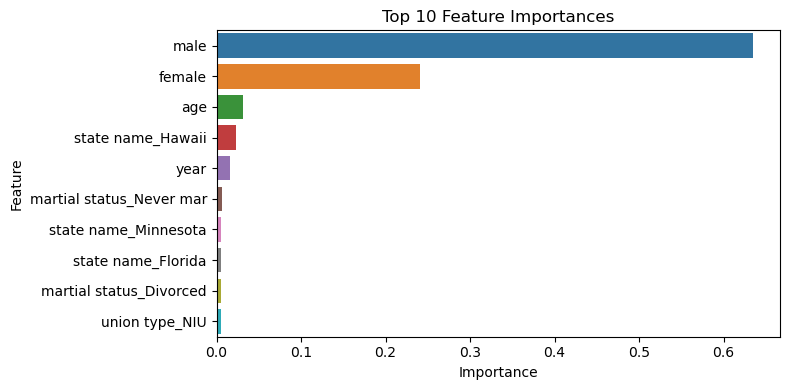

In [62]:
# Examine features
feature_importances = model.feature_importances_

# Creating DataFrame with feature names and their importance scores
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))  # Show top 10 features
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

plt.show()


## Re-designing the model for improved efficiency:
Only a few of the features during the first initiation appear to have a large effect on the model performance. To icrease the effectiveness and performance of the model, it will be rerun with the top features of importance, gender, age, and year.

In [63]:
# Calculate the average salary again but now by just year, age, and sex
avg_income_data_less_features = (
    combined_df
    .groupBy(['year','age', 'sex_1'])
    .agg(F.mean('incwage').alias('avg_income')) 
)
avg_income_data_less_features.show(5)


+----+---+------+------------------+
|year|age| sex_1|        avg_income|
+----+---+------+------------------+
|1981| 36|  male|21176.677279305353|
|1981| 60|  male| 18688.27683615819|
|1981| 37|  male|21364.150837988826|
|1981| 35|female|10368.572477064221|
|1981| 62|female|  8408.13294797688|
+----+---+------+------------------+
only showing top 5 rows



In [64]:
# Pivot to get male and female average incomes
avg_income_pivot_less_features = avg_income_data_less_features.groupBy(['year','age']).pivot('sex_1', ['male', 'female']).agg(F.first('avg_income'))
avg_income_pivot_less_features.show(5)

+----+---+------------------+-----------------+
|year|age|              male|           female|
+----+---+------------------+-----------------+
|2009| 50| 72941.98257372653|40710.38036809816|
|2007| 44| 59108.32947368421|37869.35555555556|
|1999| 42|48198.710743801654|         26580.65|
|1990| 53| 32923.18904109589|18208.58258258258|
|2011| 46| 63990.20870678617|41666.79802955665|
+----+---+------------------+-----------------+
only showing top 5 rows



In [65]:
# Calculate pay gap (percentage difference)
avg_income_pivot_less_features = avg_income_pivot_less_features.withColumn('pay_gap', 
    (avg_income_pivot_less_features['male'] - avg_income_pivot_less_features['female']) / avg_income_pivot_less_features['male'] * 100)

# Order and show final results
avg_income_pivot_less_features.orderBy('year', 'age').show(5)

+----+---+------------------+------------------+------------------+
|year|age|              male|            female|           pay_gap|
+----+---+------------------+------------------+------------------+
|1981| 25|13529.103213242453| 9360.390663390663|30.812925913458944|
|1981| 26|14301.984662576688| 9543.998777506113| 33.26801137971128|
|1981| 27|14866.549851924976| 9457.711026615969| 36.38260981318843|
|1981| 28|15898.320696721312|10065.381562099872|36.689026758809554|
|1981| 29| 17011.05642633229|10018.459039548023| 41.10619124136268|
+----+---+------------------+------------------+------------------+
only showing top 5 rows



In [66]:
# Convert to Pandas for scikit-learn model
avg_income_pandas_less_features = avg_income_pivot_less_features.orderBy('year').toPandas()
avg_income_pandas_less_features.head()

,year,age,male,female,pay_gap
0,1981,58,21213.308642,9611.429032,54.691514
1,1981,64,17084.826923,8362.919118,51.050607
2,1981,34,19720.022826,10133.969343,48.610763
3,1981,43,21364.170213,9601.723831,55.056884
4,1981,51,22493.271762,10857.176000,51.731451


In [67]:
# Data cleaning and preparation
avg_income_pandas_less_features.replace({'male': {'None': np.nan}, 'female': {'None': np.nan}, 'pay_gap': {'None': np.nan}}, inplace=True)
avg_income_pandas_less_features.fillna(0, inplace=True)

# Handle NaN variables
avg_income_pandas_less_features['male'].fillna('0', inplace=True)
avg_income_pandas_less_features['female'].fillna('0', inplace=True)
avg_income_pandas_less_features['pay_gap'].fillna('0', inplace=True)

# Convert necessary columns to float
avg_income_pandas_less_features['male'] = avg_income_pandas_less_features['male'].astype(float)
avg_income_pandas_less_features['female'] = avg_income_pandas_less_features['female'].astype(float)
avg_income_pandas_less_features['pay_gap'] = avg_income_pandas_less_features['pay_gap'].astype(float)



/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_57485/1818963439.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_57485/1818963439.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [68]:
# Define feature matrix (X) and target vector (y)
X_2 = avg_income_pandas_less_features.drop(columns=['pay_gap'])  # Dropping only pay_gap, which is the target
y_2 = avg_income_pandas_less_features['pay_gap']  # pay_gap is the target variable, which remains continuous


In [69]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)


In [70]:
# Standard scaling
scaler_2 = StandardScaler()
X_train_2 = scaler_2.fit_transform(X_train_2)
X_test_2 = scaler_2.transform(X_test_2)

In [71]:
# Initialize and fit the RandomForestRegressor model
model_2 = RandomForestRegressor()
model_2.fit(X_train_2, y_train_2)

RandomForestRegressor()

In [72]:
# Make predictions
y_pred_2 = model_2.predict(X_test_2)

In [73]:
# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test_2, y_pred_2))
print("R-squared:", r2_score(y_test_2, y_pred_2))

Mean Squared Error: 8.034616031523987
R-squared: 0.9240532087599622


Reducing features has improved model performance, as demonstrated by a lower mean squared error number and a higher r-squared value

In [74]:
# Print updated feature importances
updated_importances = model_2.feature_importances_
updated_feature_names = X_2.columns
updated_importance_df = pd.DataFrame({'Feature': updated_feature_names, 'Importance': updated_importances})
updated_importance_df = updated_importance_df.sort_values(by='Importance', ascending=False)
print("\nUpdated Feature Importances:")
print(updated_importance_df)


Updated Feature Importances:
  Feature  Importance
1     age    0.451990
3  female    0.405562
2    male    0.089319
0    year    0.053128


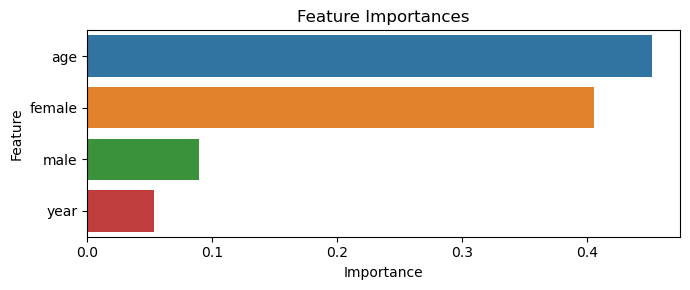

In [75]:
# Re-examine features
updated_feature_importances = model_2.feature_importances_

# Create a new DataFrame with updated feature names and their importance scores
updated_importance_df = pd.DataFrame({
    'Feature': updated_feature_names,
    'Importance': updated_feature_importances
})

# Sort the DataFrame by importance (most important features at the top)
updated_importance_df = updated_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(7, 3))
sns.barplot(x='Importance', y='Feature', data=updated_importance_df.head(10))  # Show top 10 features
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

plt.show()
